In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import tensorflow as tf
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

In [2]:
sample_size =  405
width = 224
height = 224

In [3]:
files = ['A', 'B', 'C']
# file_path = "D:/TITO/Documents/BANGKIT/capstone/protoype2/data4/{}"
file_path = "C:/laragon/www/Project/Bloomy/dataset/{}"
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(file_path.format(col))
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)
        if i.endswith('.png'):
            data[col].append(i)

In [4]:
print(len(data['A']))
print(len(data['B']))
print(len(data['C']))

135
135
135


In [5]:
pd.DataFrame(data).head()

,A,B,C
0,bawal-a-0.png,4c5a8d75a1c0f47a324e0fec5d1148c1_jpeg.rf.076d4...,bawal-c-0-rem.png
1,bawal-a-1.png,4c5a8d75a1c0f47a324e0fec5d1148c1_jpeg.rf.58b89...,bawal-c-1-rem.png
2,bawal-a-10.png,4c5a8d75a1c0f47a324e0fec5d1148c1_jpeg.rf.7715f...,bawal-c-10-rem.png
3,bawal-a-11.png,4ce4aefe3cbda4b851c856823d4fd1da_jpeg.rf.06c94...,bawal-c-11-rem.png
4,bawal-a-12.png,4ce4aefe3cbda4b851c856823d4fd1da_jpeg.rf.5f643...,bawal-c-12-rem.png


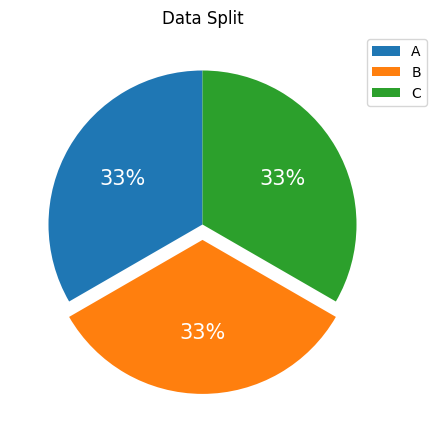

In [6]:
sizes = [len(data['A']), len(data['B']), len(data['C'])]
explode = (0, 0.1, 0) 

plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color': "w", "fontsize": 15}, startangle=90, explode=explode)
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [7]:
start = time.time()
image_data = []
image_target = []

for title in files:
    os.chdir(file_path.format(title))
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
        if counter == sample_size:
            break
    clear_output(wait=True)
    print("Compiled Class",title)
calculate_time = time.time() - start
print("Calculate Time",round(calculate_time,5))

Compiled Class C
Calculate Time 14.59656


In [8]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(405, 224, 224, 3)

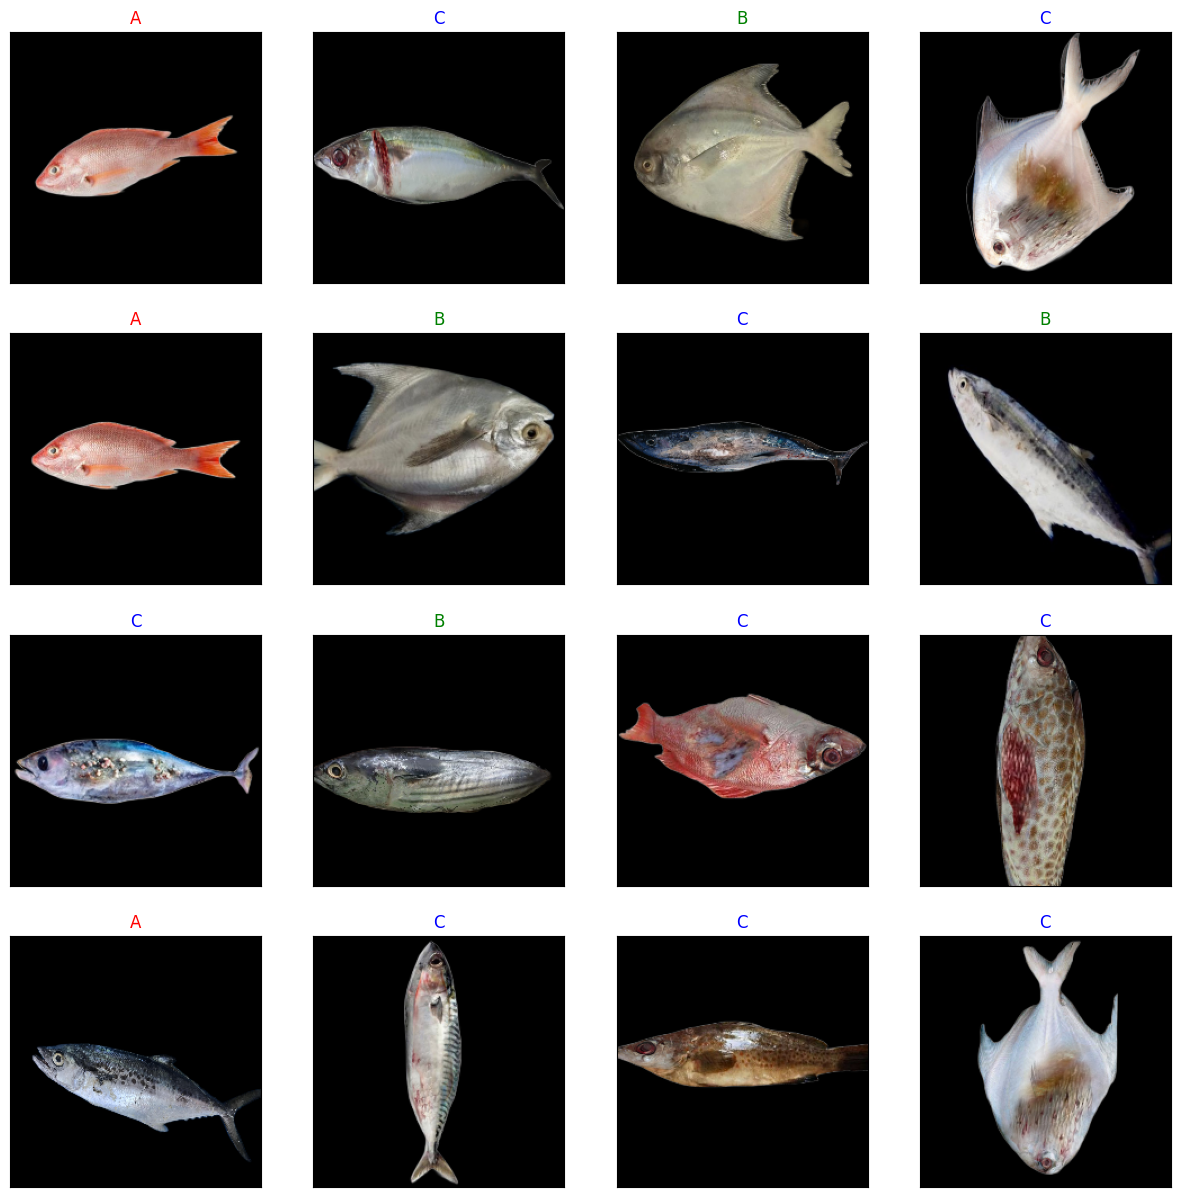

In [9]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='A':
        c='red'
    elif image_target[fig]=='B':
        c='green'
    else:
        c='blue'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [10]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [11]:
X = image_data / 255.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)


In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(width, height, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [13]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(3, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,422,339
Trainable params: 164,355
Non-tr

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=10,
                                                restore_best_weights=True)


In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0000001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

def lr_scheduler(epoch):
    return 0.001 * np.exp(-0.1 * epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [17]:
# Reduce batch size
batch_size = 16

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
Physical devices cannot be modified after being initialized


In [18]:
# history = model.fit(train_images, train_labels, epochs=100, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])
history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=100, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])

Epoch 1/100
18/18 [==============================] - 11s 123ms/step - loss: 1.3659 - accuracy: 0.4417 - val_loss: 0.7396 - val_accuracy: 0.6475 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 1s 47ms/step - loss: 0.7055 - accuracy: 0.6890 - val_loss: 0.5863 - val_accuracy: 0.7623 - lr: 9.0484e-04
Epoch 3/100
18/18 [==============================] - 1s 47ms/step - loss: 0.5355 - accuracy: 0.7880 - val_loss: 0.4564 - val_accuracy: 0.8934 - lr: 8.1873e-04
Epoch 4/100
18/18 [==============================] - 1s 42ms/step - loss: 0.4236 - accuracy: 0.8445 - val_loss: 0.4061 - val_accuracy: 0.8852 - lr: 7.4082e-04
Epoch 5/100
18/18 [==============================] - 1s 46ms/step - loss: 0.3701 - accuracy: 0.8587 - val_loss: 0.3518 - val_accuracy: 0.9180 - lr: 6.7032e-04
Epoch 6/100
18/18 [==============================] - 1s 42ms/step - loss: 0.3170 - accuracy: 0.8763 - val_loss: 0.3447 - val_accuracy: 0.9016 - lr: 6.0653e-04
Epoch 7/100
18/18 [=============================

4/4 - 0s - loss: 0.2683 - accuracy: 0.9344 - 236ms/epoch - 59ms/step


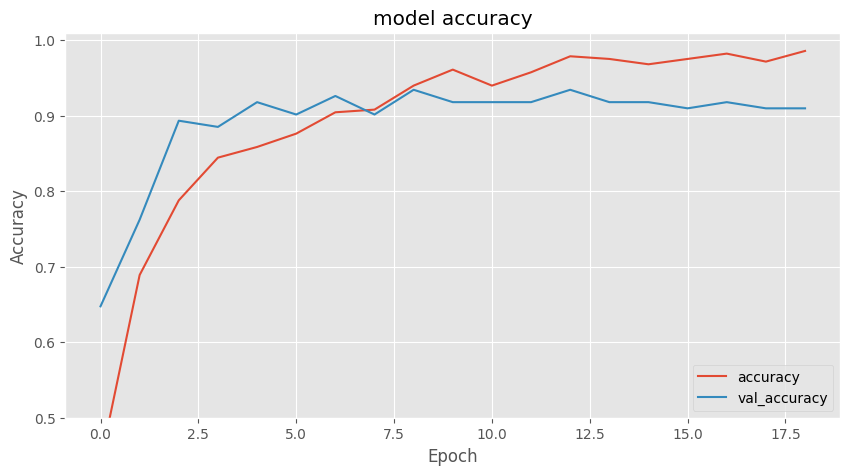

In [19]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title('model accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

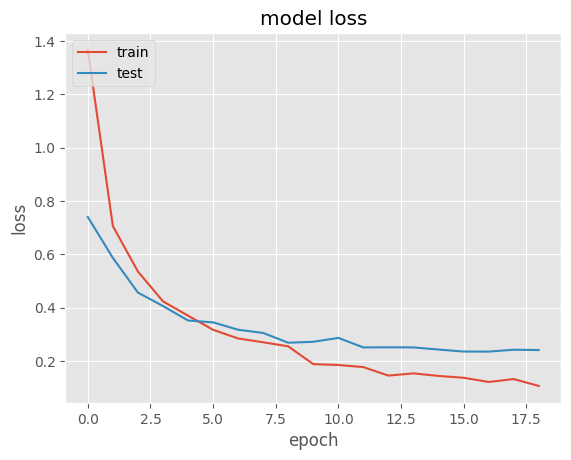

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
result=model.evaluate(test_images, test_labels)

4/4 [==============================] - 0s 46ms/step - loss: 0.2683 - accuracy: 0.9344


In [22]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 0.268348753452301
accuracy : 0.9344262480735779


4/4 [==============================] - 1s 44ms/step


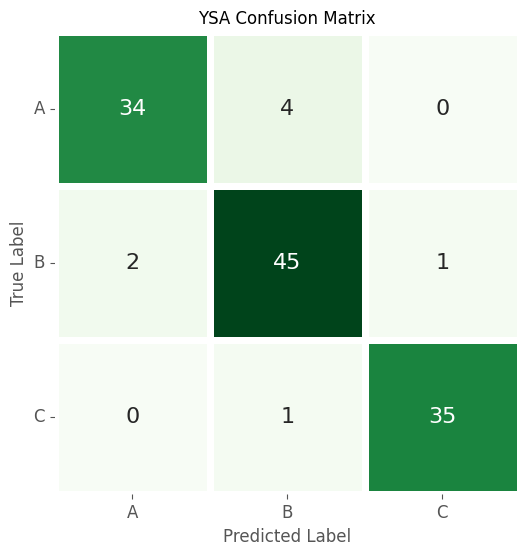

In [23]:
y_pred = model.predict(test_images)

def toClass(pred):

    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index

    return class_

cm = confusion_matrix(test_labels,toClass(y_pred))

df1 = pd.DataFrame(columns=["A","B", "C"], index= ["A","B", "C"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("YSA Confusion Matrix", size = 12)
plt.show()

In [24]:
def Prediction(image):

    global width, height, files, labels

    img = cv2.resize(image,(width,height))
    test = np.expand_dims(img, axis=0)
    test = img / 255.0

    pred = model.predict(np.array([image]), batch_size=1).argmax()

    return labels.inverse_transform([pred])[0]


1/1 [==============================] - 0s 27ms/step


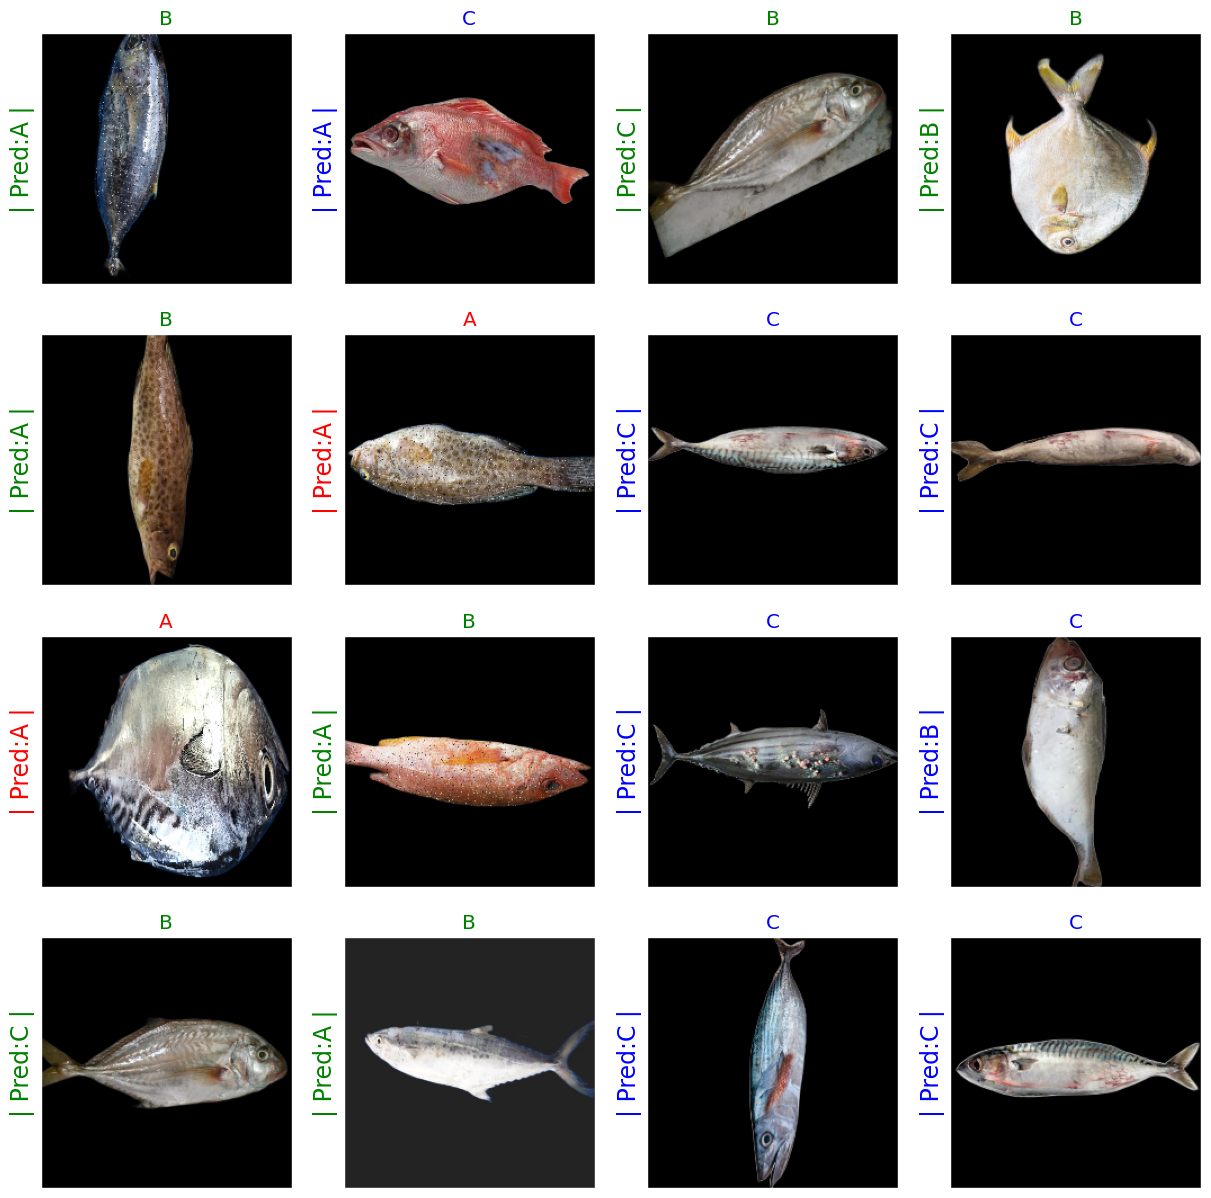

In [25]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='A':
        c='red'
    elif image_target[fig]=='B':
        c='green'
    else:
        c='blue'
    plt.title(image_target[fig], color=c)
    plt.ylabel("| Pred:{} |".format(Prediction(image_data[fig])),fontsize=17, color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

1/1 [==============================] - 0s 26ms/step
Prediction range:
Minimum value: 0.02150197
Maximum value: 0.8245267
Grade: C
Bad


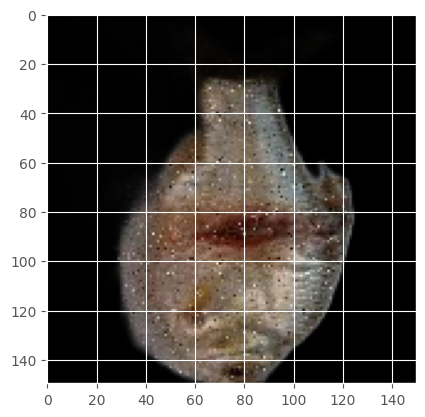

In [40]:

# user_path = r"C:\laragon\www\Project\Bloomy\img\output"
user_path = r"C:\laragon\www\Project\Bloomy\img\output"

image_files = os.listdir(user_path)

index = 11
image_file = os.path.join(user_path, image_files[index])

img = image.load_img(image_file, target_size=(150, 150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0 

classes = model.predict(x, batch_size=1)
nilai_min = np.min(classes)
nilai_max = np.max(classes)

print("Prediction range:")
print("Minimum value:", nilai_min)
print("Maximum value:", nilai_max)

class_list = ['A', 'B', 'C'] 

predicted_class = class_list[np.argmax(classes[0])]
print('Grade:', predicted_class)

if predicted_class == 'A':
    print('Good')
   

elif predicted_class == 'B':
    print('Medium')


elif predicted_class == 'C':
    print('Bad')

In [27]:
# # file_location = 'D:\\Users\\Andra\Documents\\Bloomy\\prototype\\fish_grading.h5'
# # file_location = 'C:\laragon\www\Project\Bloomy\model\\fishgrading.h5'
# file_location = 'D:\\TITO\\Documents\\BANGKIT\\capstone\\protoype2\\fish_grading.h5'

# model.save(file_location)